<a href="https://colab.research.google.com/github/Alla-ud-din/Classes-Q3-Q4/blob/master/LangGraph/AGENTIC_PROJECTS/01_human_interactions_Command.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Project 01: User-Chat-Interactions**

---

### **Objective:**
Make your chat-agent developed in 00_chat_agent smarter by allowing it to:
1. Get help from a human assistant when needed.
2. Pause and ask the user for extra information if something is unclear.
3. Personalize its answers using long-term memory.
4. Offloading conversation to Human

**Note:** This project builds on the skills learned in Project 00 and prepares you for advanced Agentic AI features like dynamic workflows and user personalization.

---

### **Requirements:**

1. **Human Assistant Interrupts (Static Interrupts):**
   - Add a feature where your chatbot can **pause** and connect to a human assistant if needed.
   - This can be a **static interrupt**—you decide when the chatbot needs help from a human.
   - Example: If the chatbot can’t answer a question or doesn’t have enough information, it stops and sends the question to a human for assistance.

**Reference Material:**
- [Static Breakpoints](https://github.com/panaversity/learn-agentic-ai/blob/main/12_langchain_ecosystem/langgraph/course-notebooks/module-3/2_breakpoints.ipynb)

2. **Ask the User for More Information (Dynamic Interrupts):**
   - Make the chatbot smart enough to **pause its workflow** and ask the user for more information when it’s confused.
   - Steps:
     - Add a **decision step** after each user message.
     - If the chatbot detects a question or needs more details, it pauses and asks the user to clarify.
     - The user can:
       - **Answer the question** to help the chatbot.
       - **Skip the question** and let the chatbot guess the best answer.

**Reference Material:**
- [Dynamic Breakpoints](https://github.com/panaversity/learn-agentic-ai/blob/main/12_langchain_ecosystem/langgraph/course-notebooks/module-3/4_dynamic_breakpoints.ipynb)
- [Editing State](https://github.com/panaversity/learn-agentic-ai/blob/main/12_langchain_ecosystem/langgraph/course-notebooks/module-3/3_edit_state_human_feedback.ipynb)

3. **(Optional) Personalize Using Long-Term Memory:**
   - Use a memory system to **save important details** about the user.
   - Examples of what to remember:
     - Preferences (e.g., favorite subjects, preferred clothing styles).
     - Recurring needs (e.g., study schedules, favorite recipes).
   - Use this memory to give **better and more personal answers** over time.

**Tools:** Use **LangGraph Memory Store** to save and retrieve user data.

**Reference Material:**
- [Concept](https://langchain-ai.github.io/langgraph/concepts/memory/#long-term-memory)
- [Memory Template](https://github.com/langchain-ai/memory-template)

*Note:* This is an optional step. Focus on completing the first two requirements before attempting long-term memory integration if you feel confident.

---

### **Deliverables:**
- A working chatbot prototype with:
  1. Human assistant interrupts.
  2. Dynamic user clarifications.
  3. Long-term memory for personalization (Optional).

---

## **Submission Form**

Submit your projects here:  
[**Project Submission Form**](https://forms.gle/yB6X4TzE2dCVThCj8)

---

### **Example Scenarios:**

1. **Human Assistant Interrupt:**
   - User asks: *"Can you help with tax calculations?"*
   - Chatbot: *"Let me connect you to a human assistant for this question."*
   
2. **Dynamic Interrupt:**
   - User asks: *"Plan a study schedule for me."*
   - Chatbot: *"What is your next exam date? Should I include break times?"*

3. **Personalized Memory (Optional):**
   - User: *"What should I study today?"*
   - Chatbot: *"Last time, you said your math exam is next week. Let’s focus on trigonometry today."*

---

### **Outcomes:**
By completing this project, you will:
1. Learn how to connect a chatbot with a human assistant.
2. Understand how to make chatbots pause and ask for clarifications when needed.
3. Use long-term memory to personalize chatbot responses.

In [9]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_google_genai tavily-python langchain_community

In [10]:
import os
from google.colab import userdata

os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")

GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')

In [11]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    max_retries=2,
    api_key=GEMINI_API_KEY
)

from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=1)
# llm.invoke("greet me")
# tavily_search.invoke("What's a 'node' in LangGraph?")

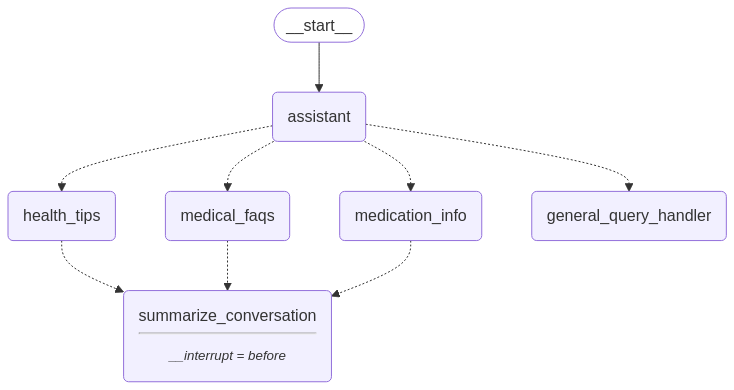

In [22]:
from typing import Annotated, Any, Literal
from typing_extensions import TypedDict
from langgraph.types import Command
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage, AnyMessage, SystemMessage, RemoveMessage
from langgraph.errors import NodeInterrupt
from IPython.display import Image, display
from langgraph.graph.state import CompiledStateGraph
from langgraph.checkpoint.memory import MemorySaver

# Define the State class to manage the state transitions
class State(TypedDict):
    user_query: Annotated[list[AnyMessage], add_messages]  # Stores user input messages
    response: Annotated[list[AnyMessage], add_messages]  # Stores assistant responses
    summary: str  # Stores a summary of the conversation

# Initialize a state graph builder
graph_builder = StateGraph(State)

# Define tool: Health Tips
def health_tips(state: State) -> Command[Literal["summarize_conversation"]]:
    """Provide health tips using Tavily Search."""
    user_query = state['user_query'][-1].content  # Extract user query
    tavily_response = tavily_search.invoke(user_query)  # Call Tavily Search API
    formatted_response = "\n\n".join(
            f"-  {item.get('content', 'No content')} Source: {item.get('url', 'No URL')}\n  "
            for item in tavily_response
        )
    return Command (
        update = {"response": [AIMessage(content=formatted_response)]},  # Return the response
        goto = "summarize_conversation"
        )

# Define tool: Medical FAQs
def medical_faqs(state: State) -> Command[Literal["summarize_conversation"]]:
    """Provide medical FAQs for a given condition using Tavily Search."""
    user_query = state['user_query'][-1].content  # Extract user query
    query = f"Medical FAQs about: {user_query}"
    tavily_response = tavily_search.invoke(query)  # Call Tavily Search API
    formatted_response = "\n\n".join(
            f"-  {item.get('content', 'No content')} Source: {item.get('url', 'No URL')}\n  "
            for item in tavily_response
        )
    return Command (
        update = {"response": [AIMessage(content=formatted_response)]},   # Return the response
        goto = "summarize_conversation"
    )

# Define tool: Medication Info
def medication_info(state: State) -> Command[Literal["summarize_conversation"]]:
    """Provide information about medications."""
    user_query = state['user_query'][-1].content  # Extract user query
    query = f"Medication information for: {user_query}"
    tavily_response = tavily_search.invoke(query)  # Call Tavily Search API
    formatted_response = "\n\n".join(
            f"-  {item.get('content', 'No content')} Source: {item.get('url', 'No URL')}\n  "
            for item in tavily_response
        )

    return Command(
        update = {"response": [AIMessage(content=formatted_response)]},   # Return the response
        goto = "summarize_conversation"
    )

# Define tool: General Query Handler
def general_query_handler(state: State) -> State:
    """Handle general queries unrelated to medical topics."""
    user_query = state['user_query'][-1].content  # Extract user query
    response = (f"It seems like your query is unrelated to medical topics. "
                f"Here's a general response to '{user_query}': I'm here to help, "
                "but I specialize in health-related queries. Could you clarify or ask something health-related?")
    return Command (
        update = {"response": [SystemMessage(content=response)]},   # Return the response
        goto = END
    )

# List of tools
tools = [health_tips, medical_faqs, medication_info, general_query_handler]

# Bind tools to the LLM
llm_with_tools = llm.bind_tools(tools)


prompt = f"""You are a helpful medical assistant designed to assist users with their health-related queries.
          You have access to specialized tools for providing health tips, answering medical FAQs, giving medication information, and handling general medical inquiries.

          - If a user's query falls under any of these categories, return the appropriate tool call.
          - If a user's query is not related to health-related topics, call general_query_handler tool.
          - If you need more details to determine the correct response, ask the user to clarify by replying: 'Can you clarify?'
          - For general prompts like greetings, respond naturally without using a tool.
          - If the user indicates they want to end the conversation, respond with 'END'.

          Ensure accuracy and relevance in all responses while prioritizing user health and safety.
          """
sys_msg = SystemMessage(content=prompt)
# Define the assistant node
def assistant(state: State) -> Command[Literal["health_tips", "medical_faqs", "medication_info", "general_query_handler"]]:
    """Generate a response from the assistant using the LLM and tools."""
    # Get summary if it exists
    summary = state.get("summary", "")
    # If there is summary, then we add it
    if summary:
        # Add summary to system message
        system_message = f"Summary of conversation earlier and prompt: Summary: {summary}\n\nPrompt: {sys_msg}"
        response = llm_with_tools.invoke([SystemMessage(content=system_message), state["user_query"][-1]])  # Get response from the LLM
    else:
        response = llm_with_tools.invoke([sys_msg, state["user_query"][-1]])  # Get response from the LLM
    if "Can you clarify?" in response.content:
        raise NodeInterrupt(f"Received input is not clear: {state['user_query'][-1]}")
    if "END" in response.content:
        goto = END
    try:
        if hasattr(response, 'tool_calls') and len(response.tool_calls) > 0:  # Check if tool_calls is present
          # print("\n\nTool call present", response.tool_calls[-1]['name'])
          goto = response.tool_calls[-1]['name']
        else:
          goto = END
    except Exception as e:
        print(f"[ERROR in tool_calling]: {e}")
        goto =  END  # Default to END on error
    # print("Response in assistant: ", response.tool_calls)
    return Command(
        update = {"response": [response]},  # Return the response
        goto = goto
    )

# Define tool calling logic
# def tool_calling(state: State) -> Any:
#     """Determine the next tool to call based on model responses."""
#     if "END" in state['response'][-1].content:
#       return END
#     try:
#         if state['response'] and hasattr(state['response'][-1], 'tool_calls') and len(state['response'][-1].tool_calls) > 0:
#             tool_name = state['response'][-1].tool_calls[-1].get("name", None)  # Extract tool name
#             if tool_name:
#                 return tool_name  # Call the specific tool
#         return END  # If no tool is needed, go directly to END
#     except Exception as e:
#         print(f"[ERROR in tool_calling]: {e}")
#         return END  # Default to END on error

# Define the summarize conversation logic
def summarize_conversation(state: State) -> State:
    """Summarize the conversation so far."""
    # Get the existing summary (if any)
    summary = state.get("summary", "")
    # Create the summarization prompt
    if summary:
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add the summarization prompt to the history
    messages = state["user_query"] + state["response"] + [HumanMessage(content=summary_message)]

    # Filter valid messages (non-empty content)
    valid_messages = [
        message for message in messages
        if hasattr(message, 'content') and message.content  # Ensure 'content' exists and is not empty
    ]

    # Get the response from the LLM
    response = llm.invoke(valid_messages)

    # Create RemoveMessage objects for all but the two most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["user_query"][:-1] + state["response"][:-1]]

    # Return the updated state
    return Command(
        update = {
        "summary": str(response.content),  # Update the summary
        "response": [state["response"][-1]],  # Keep only the summarization response
        },
        goto = END
    )


# Initialize the state graph builder
builder: StateGraph = StateGraph(State)

# Define nodes in the graph
builder.add_node("assistant", assistant)
builder.add_node("health_tips", health_tips)
builder.add_node("medical_faqs", medical_faqs)
builder.add_node("medication_info", medication_info)
builder.add_node("general_query_handler", general_query_handler)
builder.add_node("summarize_conversation", summarize_conversation)

# Define edges in the graph
builder.add_edge(START, "assistant")  # Start with the assistant node
# builder.add_conditional_edges("assistant", tool_calling)  # Add conditional edges for tool calling

# Tools transition to summarize_conversation
# builder.add_edge("health_tips", "summarize_conversation")
# builder.add_edge("medical_faqs", "summarize_conversation")
# builder.add_edge("medication_info", "summarize_conversation")
# This was the problem, general_query_handler should point to END, not a node called "END"
# builder.add_edge("general_query_handler", END) # Changed from builder.add_edge("general_query_handler", "END")

# Summarize conversation transitions to END
# builder.add_edge("summarize_conversation", END)

# Initialize memory to save conversation
memory: MemorySaver = MemorySaver()

# Compile the state graph
graph: CompiledStateGraph = builder.compile(interrupt_before = ["summarize_conversation"], checkpointer=memory)

# Visualize the graph
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


In [23]:
# Specify a thread configuration
config = {"configurable": {"thread_id": "1"}}

In [24]:
# # Main interaction loop

exit = True
while exit:
    user_input = input("Welcome to HealthHub! How can I assist you today?  ")
    # if user_input.lower() in ["quit", "exit", "q"]:
    #     print("\n\nGoodbye! Stay healthy and take care!")
    #     break


    for result in graph.stream({"user_query": user_input}, config, stream_mode="updates"):
        # print("\n\nResult:", result)
        if "assistant" in result and result["assistant"] and result['assistant']['response'][-1].content:
            if "END" in result['assistant']['response'][-1].content:
                print("\n\nGoodbye! Stay healthy and take care!")
                exit = False
                break
            print("Assistant:", result['assistant']['response'][-1].content)
        for tool in ["health_tips", "medical_faqs", "medication_info", "general_query_handler"]:
            if tool in result:
                print("Assistant_tool: ", result[tool]['response'][-1].content)

        if "__interrupt__" in result and result["__interrupt__"] and "Received input is not clear" in result["__interrupt__"][-1].value: # Check if '__interrupt__' key exists and is not empty
            user_input_clear = input("Kindly explain your query?  ")
            # if user_input_clear.lower() in ["quit", "exit", "q"]:
            #     print("\n\nGoodbye! Stay healthy and take care!")
            #     exit = False
            #     break
            graph.update_state(config, {"user_query": user_input + user_input_clear})
            for result in graph.stream(None, config, stream_mode="updates"):
                print("\n\nInternal Result:", result)
                if "assistant" in result and result["assistant"] and result['assistant']['response'][-1].content:
                    if "END" in result['assistant']['response'][-1].content:
                        print("\n\nGoodbye! Stay healthy and take care!")
                        exit = False
                        break
                    print("Assistant:", result['assistant']['response'][-1].content)
                for tool in ["health_tips", "medical_faqs", "medication_info", "general_query_handler"]:
                    if tool in result:
                        print("Assistant_tool: ", result[tool]['response'][-1].content)
        if "__interrupt__" in result:
            while True:
                # Get user feedback
                user_approval = input("Are you satisfied with the response? (yes/no): ")
                # Check approval
                if user_approval.lower() == "yes":
                    # If approved, continue the graph execution
                    for result in graph.stream(None, config, stream_mode="updates"):
                        # print("\n\nResult in second interrupt:", result)
                        pass
                    break

                elif user_approval.lower() == "no":
                    user_input_detail = input("Kinly provide more details? ")
                    # if user_input_detail.lower() in ["quit", "exit", "q"]:
                    #     print("\n\nGoodbye! Stay healthy and take care!")
                    #     exit = False
                    #     break
                    # Conditionally concatenate user_input_clear if it exists
                    # if user_input_clear:
                    #     user_input_detail = f"{user_input_clear} {user_input_detail}"
                    for result in graph.stream({"user_query": user_input + user_input_detail }, config, stream_mode="updates"):
                        for tool in ["health_tips", "medical_faqs", "medication_info", "general_query_handler"]:
                            if tool in result:
                                print("Assistant_tool: ", result[tool]['response'][-1].content)

                else:
                    print("Invalid input. Please enter 'yes' or 'no'.")





Welcome to HealthHub! How can I assist you today?  How can I improve my cardiovascular health?
Assistant_tool:  -  High cholesterol and high blood pressure can make you more likely to have heart disease or a heart attack. If you’re between the ages of 40 and 59 years, taking aspirin every day may lower your risk of heart attack and stroke — but doctors don’t recommend it for everyone. Eating healthy can help lower your risk of heart disease. People who have overweight or obesity are at an increased risk for heart disease, high blood pressure, and type 2 diabetes. Getting regular physical activity can help prevent heart disease. Quitting smoking helps lower your risk of heart disease and heart attack. Managing stress can help prevent serious health problems like heart disease, depression, and high blood pressure. Source: https://odphp.health.gov/myhealthfinder/health-conditions/heart-health/keep-your-heart-healthy
  
Are you satisfied with the response? (yes/no): yes
Welcome to HealthHu

In [15]:
test = {'response': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'general_query_handler', 'arguments': '{"state": {"user_query": ["What\'s the weather forecast today?"], "response": [], "summary": ""}}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-c6ded3ca-2111-40ca-a080-7c56280c44f3-0', tool_calls=[{'name': 'general_query_handler', 'args': {'state': {'user_query': ["What's the weather forecast today?"], 'response': [], 'summary': ''}}, 'id': '081c2501-2ba9-4bbb-a628-168ec3a87c2e', 'type': 'tool_call'}], usage_metadata={'input_tokens': 275, 'output_tokens': 19, 'total_tokens': 294, 'input_token_details': {'cache_read': 0}}), SystemMessage(content="It seems like your query is unrelated to medical topics. Here's a general response to 'What's the weather forecast today?': I'm here to help, but I specialize in health-related queries. Could you clarify or ask something health-related?", additional_kwargs={}, response_metadata={}, id='7b209a97-6595-48e2-8342-c7aebcc618b4'), AIMessage(content='END', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-f4640471-5a25-4a74-a7dc-da3f26350a84-0', usage_metadata={'input_tokens': 274, 'output_tokens': 2, 'total_tokens': 276, 'input_token_details': {'cache_read': 0}})], 'user_query': [HumanMessage(content="What's the weather forecast today?", additional_kwargs={}, response_metadata={}, id='7e1bda9e-ba02-4204-9f92-83ed0617aa0b'), HumanMessage(content='thank you. see you next time', additional_kwargs={}, response_metadata={}, id='4787ea8d-e8a2-477a-b4c6-277d1872157b')]}

In [16]:
if "END" in test['response'][-1].content:
      print("END")

END


In [17]:
result["health_tips"]["response"][-1].content

KeyError: 'health_tips'

In [ ]:
Response in assistant:  content='' additional_kwargs={'function_call': {'name': 'medical_faqs', 'arguments': '{"state": {"user_query": ["common symptoms of diabetes"], "response": [], "summary": ""}}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []} id='run-a51da32a-17ae-49db-85f9-b1ed909097aa-0' tool_calls=[{'name': 'medical_faqs', 'args': {'state': {'user_query': ['common symptoms of diabetes'], 'response': [], 'summary': ''}}, 'id': '3a6bbaed-e848-40f0-9016-0014cb2d3413', 'type': 'tool_call'}] usage_metadata={'input_tokens': 274, 'output_tokens': 13, 'total_tokens': 287, 'input_token_details': {'cache_read': 0}}

In [ ]:
snapshot = graph.get_state(config)
# snapshot

In [ ]:
snapshot.next

In [ ]:
graph.update_state(config,{"user_query": "I have headache since morning. what should i do?"})
for result1 in graph.stream(None, config, stream_mode="updates"):
    print("Inrernal Result: ", result1)

In [ ]:
for result1 in graph.stream(None, config, stream_mode="updates"):
    print("Inrernal Result: ", result1)

In [ ]:
snapshot.values['response'][-1].content

In [ ]:
from google.colab import drive
drive.mount('/content/drive')